In [7]:
import pandas as pd

# Load the datasets
applications_df = pd.read_csv('cleaned_applications.csv')
branches_df = pd.read_csv('cleaned_branches.csv')
customers_df = pd.read_csv('cleaned_customers.csv')
defaults_df = pd.read_csv('cleaned_defaults.csv')
loans_df = pd.read_csv('cleaned_loans.csv')
transactions_df = pd.read_csv('cleaned_transactions.csv')

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [8]:
# Merge relevant dataframes for Default Risks analysis
# We need data from loans_df (Loan_Amount, Interest_Rate, Overdue_Amount)
# customers_df (Credit_Score) and defaults_df (Default_ID to create Default_Flag)

# Merge loans and customers on Customer_ID
loan_customer_df = pd.merge(loans_df, customers_df[['Customer_ID', 'Credit_Score']], on='Customer_ID', how='left')

# Create a Default_Flag in loan_customer_df based on whether a Loan_ID exists in defaults_df
loan_customer_df['Default_Flag'] = loan_customer_df['Loan_ID'].isin(defaults_df['Loan_ID']).astype(int)

# Select the columns for Correlation Analysis for Default Risks
default_risk_df = loan_customer_df[['Credit_Score', 'Loan_Amount', 'Interest_Rate', 'Overdue_Amount', 'Default_Flag']]

# Merge relevant dataframes for Pairwise Correlation Heatmap
# We need data from loans_df (EMI_Amount), and defaults_df (Default_Amount, Recovery_Amount)

# Merge loans and defaults on Loan_ID
loan_default_merge_df = pd.merge(loans_df, defaults_df[['Loan_ID', 'Default_Amount', 'Recovery_Amount']], on='Loan_ID', how='left')

# Calculate Recovery_Rate. Handle potential division by zero.
loan_default_merge_df['Recovery_Rate'] = (loan_default_merge_df['Recovery_Amount'] / loan_default_merge_df['Default_Amount']).fillna(0)
loan_default_merge_df['Recovery_Rate'] = loan_default_merge_df['Recovery_Rate'].replace([float('inf'), float('-inf')], 0)


# Select the columns for Pairwise Correlation Heatmap
pairwise_corr_df = loan_default_merge_df[['EMI_Amount', 'Recovery_Rate', 'Default_Amount']].copy()

# Merge relevant dataframes for Branch-Level Correlation
# We need data from branches_df (Delinquent_Loans, Loan_Disbursement_Amount)
# We also need to calculate Branch-level Recovery_Rate from defaults_df and loans_df

# Merge loans and branches to get Branch_ID
loans_with_branch_df = pd.merge(loans_df, branches_df[['Branch_ID']], left_on='Customer_ID', right_on='Branch_ID', how='left')


# Calculate total default amount and total recovery amount per branch
branch_defaults = pd.merge(defaults_df, loans_with_branch_df[['Loan_ID', 'Branch_ID']], on='Loan_ID', how='left')
branch_recovery_summary = branch_defaults.groupby('Branch_ID').agg(
    Total_Default_Amount=('Default_Amount', 'sum'),
    Total_Recovery_Amount=('Recovery_Amount', 'sum')
).reset_index()

# Merge with branches_df to get other branch metrics
branch_correlation_df = pd.merge(branches_df[['Branch_ID', 'Delinquent_Loans', 'Loan_Disbursement_Amount']],
                                 branch_recovery_summary, on='Branch_ID', how='left')

# Calculate Branch-level Recovery_Rate. Handle potential division by zero and NaNs.
branch_correlation_df['Total_Default_Amount'] = branch_correlation_df['Total_Default_Amount'].fillna(0)
branch_correlation_df['Total_Recovery_Amount'] = branch_correlation_df['Total_Recovery_Amount'].fillna(0)

branch_correlation_df['Branch_Recovery_Rate'] = (branch_correlation_df['Total_Recovery_Amount'] / branch_correlation_df['Total_Default_Amount']).fillna(0)
branch_correlation_df['Branch_Recovery_Rate'] = branch_correlation_df['Branch_Recovery_Rate'].replace([float('inf'), float('-inf')], 0)

# Select the columns for Branch-Level Correlation
branch_corr_metrics_df = branch_correlation_df[['Delinquent_Loans', 'Loan_Disbursement_Amount', 'Branch_Recovery_Rate']].copy()

print("Data prepared for analysis.")

Data prepared for analysis.


In [9]:
# Correlation Analysis for Default Risks
default_risk_corr = default_risk_df.corr()

print("Correlation Matrix for Default Risks:")
display(default_risk_corr)

Correlation Matrix for Default Risks:


Credit_Score  Loan_Amount  Interest_Rate  Overdue_Amount  \
Credit_Score        1.000000     0.000139       0.002457        0.001570   
Loan_Amount         0.000139     1.000000      -0.003201        0.008400   
Interest_Rate       0.002457    -0.003201       1.000000       -0.002199   
Overdue_Amount      0.001570     0.008400      -0.002199        1.000000   
Default_Flag       -0.001580    -0.003313      -0.003750       -0.000687   

                Default_Flag  
Credit_Score       -0.001580  
Loan_Amount        -0.003313  
Interest_Rate      -0.003750  
Overdue_Amount     -0.000687  
Default_Flag        1.000000

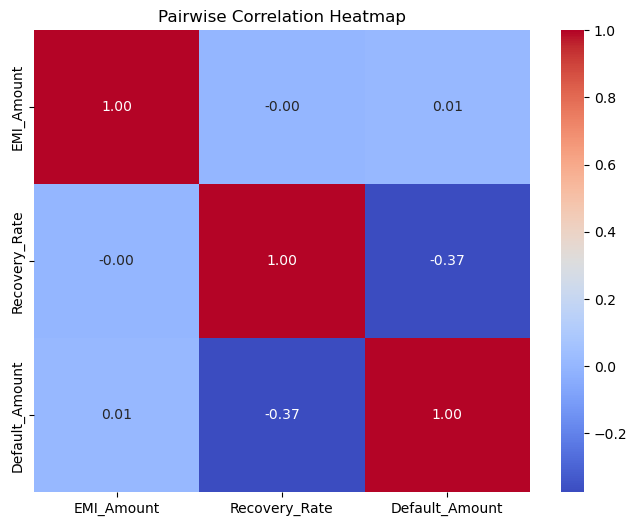

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairwise Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pairwise_corr_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pairwise Correlation Heatmap')
plt.show()

In [11]:
# Branch-Level Correlation
branch_correlation = branch_corr_metrics_df.corr()

print("Correlation Matrix for Branch-Level Metrics:")
display(branch_correlation)

Correlation Matrix for Branch-Level Metrics:


Delinquent_Loans  Loan_Disbursement_Amount  \
Delinquent_Loans                  1.000000                  0.023648   
Loan_Disbursement_Amount          0.023648                  1.000000   
Branch_Recovery_Rate                   NaN                       NaN   

                          Branch_Recovery_Rate  
Delinquent_Loans                           NaN  
Loan_Disbursement_Amount                   NaN  
Branch_Recovery_Rate                       NaN